# ImageNet NCCL profiling
- 3 Epochs, full dataset = 1281167 images
- Runs on Summit
- Batch size 64 (close to best training performance)
- Horovod, NCCL backend
- Data collected for each rank w/ NCCL_DEBUG flags

In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import DataSet
from textwrap import wrap
import seaborn as sns
from collections import Counter

# Load the data
files = ['../logs/real/8_nodes_batchsize_64/j_937039/']

d = DataSet.DataSet()
for f in files:
    d.parseInput(f, inputType='nccl')

Parsing ../logs/real/8_nodes_batchsize_64/j_937039/nccl.937039.r9.w ; 9 rank, 8 nodes
Parsing ../logs/real/8_nodes_batchsize_64/j_937039/nccl.937039.r1.w ; 1 rank, 8 nodes
Parsing ../logs/real/8_nodes_batchsize_64/j_937039/nccl.937039.r39.w ; 39 rank, 8 nodes
Parsing ../logs/real/8_nodes_batchsize_64/j_937039/nccl.937039.r18.w ; 18 rank, 8 nodes
Parsing ../logs/real/8_nodes_batchsize_64/j_937039/nccl.937039.r36.w ; 36 rank, 8 nodes
Parsing ../logs/real/8_nodes_batchsize_64/j_937039/nccl.937039.r5.w ; 5 rank, 8 nodes
Parsing ../logs/real/8_nodes_batchsize_64/j_937039/nccl.937039.r35.w ; 35 rank, 8 nodes
Parsing ../logs/real/8_nodes_batchsize_64/j_937039/nccl.937039.r47.w ; 47 rank, 8 nodes
Parsing ../logs/real/8_nodes_batchsize_64/j_937039/nccl.937039.r25.w ; 25 rank, 8 nodes
Parsing ../logs/real/8_nodes_batchsize_64/j_937039/nccl.937039.r2.w ; 2 rank, 8 nodes
Parsing ../logs/real/8_nodes_batchsize_64/j_937039/nccl.937039.r13.w ; 13 rank, 8 nodes
Parsing ../logs/real/8_nodes_batchsize_6

## Plotting preferences

In [13]:
golden = 1.61803398875
figWidth = 5. # inches
figLength = figWidth/golden
figSize1x1 = (figWidth, figLength)

rcParams['font.sans-serif'] = 'Arial'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'
rcParams['axes.labelsize'] = '12'
rcParams['xtick.labelsize'] = '12'
rcParams['ytick.labelsize'] = '12'
rcParams['legend.labelspacing'] = '0.1'
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['ytick.right'] = True
rcParams['xtick.top'] = True
rcParams['axes.linewidth'] = 2.0
rcParams['xtick.major.size'] = 3.5
rcParams['xtick.major.width'] = 1.5
rcParams['xtick.minor.size'] = 2.5
rcParams['xtick.minor.width'] = 1.0
rcParams['ytick.major.size'] = 3.5
rcParams['ytick.major.width'] = 1.5
rcParams['ytick.minor.size'] = 2.5
rcParams['ytick.minor.width'] = 1.0
rcParams['lines.markersize'] = 7
rcParams['lines.linewidth'] = 1.5

markers1 = np.array(['o', '^', 's', 'x', 'd', 'v'])
markers2 = np.array(['s', 'o', 'x', '*'])
# Other options: Dark2, Pastel1, Pastel2, Accent,
# Set1, Set2, Set3, tab10, tab20, tab20b, tab20c
colors = sns.color_palette('muted') + sns.color_palette('dark',)

## NCCL AllReduce histogram

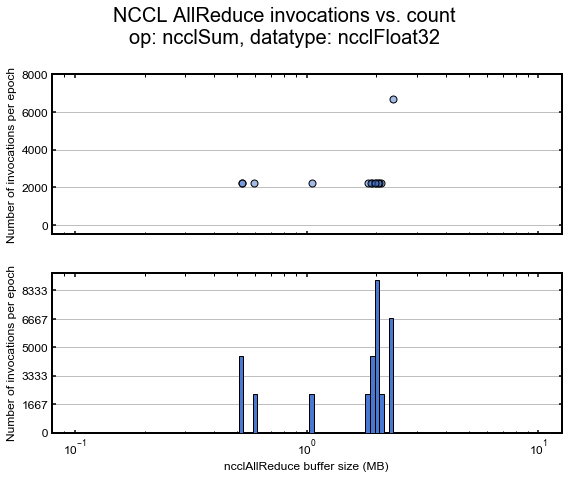

In [19]:
# data collected for 8 node runs
ranks = sorted(d._hash[8].keys())
op, datatype = 'ncclSum', 'ncclFloat32'

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6.))
plt.suptitle('NCCL AllReduce invocations vs. count\n'
             +'op: {}, datatype: {}'.format(op, datatype), y=1.1, fontsize=20)

# 4 Bytes * count
num_epochs = 3.
nbytes = np.array(4*d._hash[8][0][op][datatype])
nbytes_to_count = Counter(nbytes)

# MegaBytes
x = np.array(list(nbytes_to_count.keys()))
y = np.array([nbytes_to_count[nb]/num_epochs for nb in x])

# Plot MegaBytes vs. Count
plt.sca(axs.flatten()[0])
plt.scatter(x/10.**6, y, color=colors[0], marker='o',
            facecolor=mpl.colors.ColorConverter().to_rgba(colors[0], alpha=0.5),
            edgecolor=mpl.colors.ColorConverter().to_rgba('k', alpha=1.0), zorder=5)
plt.ylim(-500, 8000)
plt.gca().yaxis.grid(True)
plt.ylabel('Number of invocations per epoch')


# Plot MegaBytes vs. Count
plt.sca(axs.flatten()[1])
plt.xscale('log')
bins = np.logspace(-1,1,num=100)
plt.hist(nbytes/10.**6, bins=bins, color=colors[0], edgecolor='k', zorder=5)
y_vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:3.0f}'.format(x/num_epochs) for x in y_vals])
#plt.ylim(-1000, 22000)
plt.gca().yaxis.grid(True)
plt.xlabel('ncclAllReduce buffer size (MB)')
plt.ylabel('Number of invocations per epoch')
plt.tight_layout()

plt.savefig('figs/NCCL_count_log.png', dpi=150, bbox_inches='tight')